# Time Series Analysis and Climate Change

Notebook adapted from https://towardsdatascience.com/time-series-analysis-and-climate-change-7bb4371021e
   Changes to fit techniques learned in this class

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import YearEnd
import matplotlib.pyplot as plt
%matplotlib inline

# Pulling the data

In [3]:
# Read in the raw temperature and emissions datasets (they are in CSV format) 
# raw_t : An estimate of global surface temperature change
#      https://data.giss.nasa.gov/gistemp/
# raw_e : An estimate of CO₂ emissions, in metric tons per capita, from the World Bank 
#      https://data.worldbank.org/indicator/EN.ATM.CO2E.PC 
#      https://data.worldbank.org/indicator/EN.ATM.CO2E.KT   ... this file is total CO2 (more depressing)
raw_t = pd.read_csv('../data/GLB.Ts+dSST.csv', skiprows=1)
raw_e = pd.read_csv('../data/API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3159114.csv', skiprows=3)

In [27]:
# Investigate how the raw data looks
raw_t.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
135,2015,0.81,0.87,0.90,0.75,0.75,0.79,0.71,.79,.82,1.07,1.03,1.10,.87,.84,.82,0.80,.77,.97
136,2016,1.15,1.35,1.31,1.07,0.91,0.77,0.82,1.00,.88,.90,.91,.83,.99,1.01,1.20,1.10,.86,.89
137,2017,0.98,1.13,1.13,0.92,0.89,0.70,0.82,.87,.76,.88,.86,.89,.90,.90,.98,0.98,.80,.83
138,2018,0.77,0.85,0.91,0.87,0.81,0.74,0.78,.73,.76,.99,.78,.89,.82,.82,.84,0.86,.75,.84
139,2019,0.87,0.92,1.11,0.97,0.85,0.86,0.90,***,***,***,***,***,***,***,.89,0.98,***,***


# Wrangling Time Series Data

## Wrangling Temperature

In [31]:
# We only want the monthly data, lets only select that and leave out the seasonal columns 
raw_t = raw_t.iloc[:,:13]
raw_t.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1880,-0.29,-0.18,-0.11,-0.20,-0.12,-0.23,-0.21,-.09,-.16,-.23,-.20,-.23
1,1881,-0.16,-0.17,0.04,0.04,0.02,-0.20,-0.07,-.03,-.14,-.21,-.22,-.11
2,1882,0.14,0.15,0.03,-0.19,-0.16,-0.26,-0.21,-.06,-.10,-.25,-.16,-.25
3,1883,-0.32,-0.39,-0.13,-0.17,-0.20,-0.13,-0.08,-.15,-.21,-.14,-.22,-.16
4,1884,-0.16,-0.08,-0.37,-0.43,-0.37,-0.41,-0.35,-.26,-.27,-.24,-.30,-.29


In [32]:
raw_t1 = raw_t.set_index('Year')
print(raw_t1.head())
raw_t2 = raw_t1.stack()
print(raw_t2.head())
print(raw_t2.index[1])

       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
Year                                                                        
1880 -0.29 -0.18 -0.11 -0.20 -0.12 -0.23 -0.21  -.09  -.16  -.23  -.20  -.23
1881 -0.16 -0.17  0.04  0.04  0.02 -0.20 -0.07  -.03  -.14  -.21  -.22  -.11
1882  0.14  0.15  0.03 -0.19 -0.16 -0.26 -0.21  -.06  -.10  -.25  -.16  -.25
1883 -0.32 -0.39 -0.13 -0.17 -0.20 -0.13 -0.08  -.15  -.21  -.14  -.22  -.16
1884 -0.16 -0.08 -0.37 -0.43 -0.37 -0.41 -0.35  -.26  -.27  -.24  -.30  -.29
Year     
1880  Jan   -0.29
      Feb   -0.18
      Mar   -0.11
      Apr    -0.2
      May   -0.12
dtype: object
(1880, 'Feb')


In [33]:
#date_str = [str(raw_t2.index[i][0]) + "-" + raw_t2.index[i][1] for i in range(len(raw_t2))]
date_str = [str(raw_t2.index.get_level_values(0)[i]) + "-" + raw_t2.index.get_level_values(1)[i] for i in range(len(raw_t2))]
raw_t2.index = pd.to_datetime(date_str, format='%Y-%b') + MonthEnd()
raw_t2.head()

1880-01-31   -0.29
1880-02-29   -0.18
1880-03-31   -0.11
1880-04-30    -0.2
1880-05-31   -0.12
Freq: M, dtype: object

In [7]:
temp_chg = pd.DataFrame(raw_t2,columns=['Avg_Anomaly_deg_C'])
print(temp_chg.Avg_Anomaly_deg_C.dtype)
temp_chg.head()


object


,Avg_Anomaly_deg_C
1880-01-31,-0.29
1880-02-29,-0.18
1880-03-31,-0.11
1880-04-30,-0.2
1880-05-31,-0.12


In [34]:
# Import Numpy, as library meant for large arrays - we will use it that we 
import numpy as np

# Define function to convert values to floats, and return a 'NaN = Not a Number' if this is not possible
def clean_anomaly_value(raw_value):
    try:
        return float(raw_value)
    except:
        return np.NaN
    
# Apply above function to all anomaly values in DataFrame
temp_chg['Avg_Anomaly_deg_C'] = temp_chg['Avg_Anomaly_deg_C'].apply(lambda raw_value: clean_anomaly_value(raw_value))

# 'Forward fill' to take care of NaN values
temp_chg.fillna(method='ffill', inplace=True)

# Show the first few elements of our newly cleaned DataFrame
temp_chg.head()

,Avg_Anomaly_deg_C
1880-01-31,-0.29
1880-02-29,-0.18
1880-03-31,-0.11
1880-04-30,-0.20
1880-05-31,-0.12


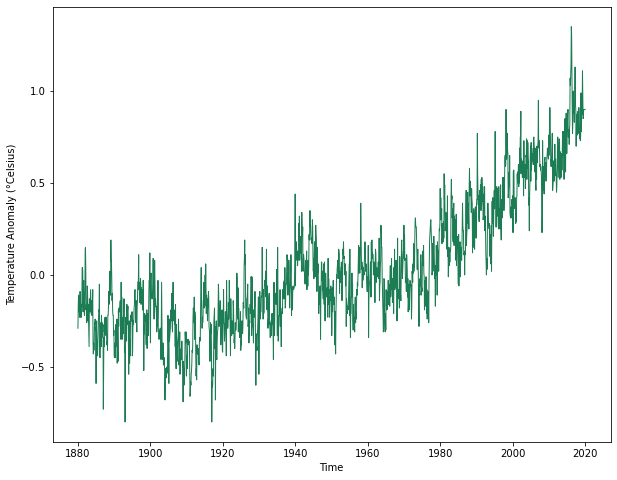

In [35]:
# Plot the data - quick and easy - using matplotlib, we will draw prettier graphs later

# Import Matplotlib
import matplotlib.pyplot as plt
# Allow for rendering within notebook
%matplotlib inline

# Create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(temp_chg, color='#1C7C54', linewidth=1.0)

In [36]:
# The data can be resampled to a different frequency, 
# lets resample it to years (end-of-year):
temp_chg.resample('A').mean().head()

,Avg_Anomaly_deg_C
1880-12-31,-0.187500
1881-12-31,-0.100833
1882-12-31,-0.110000
1883-12-31,-0.191667
1884-12-31,-0.294167


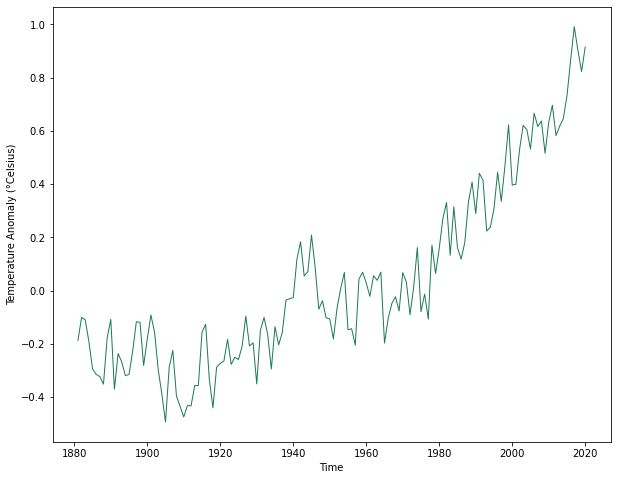

In [37]:
# Now lets visualize our resampled DataFrame

# Import Matplotlib
import matplotlib.pyplot as plt
# Allow for rendering within notebook
%matplotlib inline
# Create figure, title and plot resampled data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(temp_chg.resample('A').mean(), color='#1C7C54', linewidth=1.0)

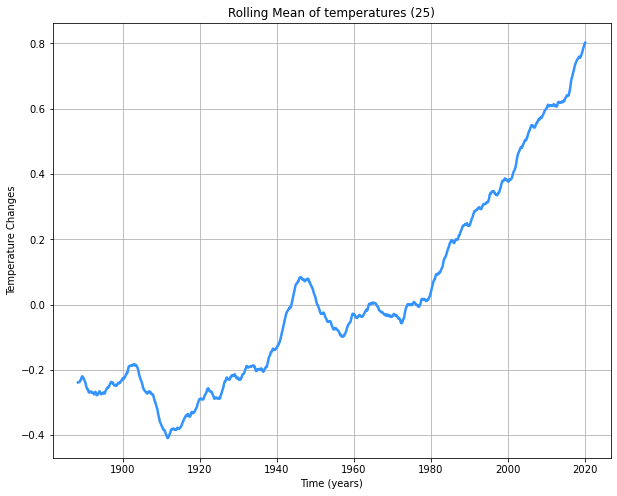

In [39]:
# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot co2 emissions data with specific colour and line thickness
ax.plot(temp_chg['Avg_Anomaly_deg_C'].rolling(100).mean(), color='#3393FF', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (years)', ylabel='Temperature Changes',
       title='Rolling Mean of temperatures (25)')

# Enable grid
ax.grid()


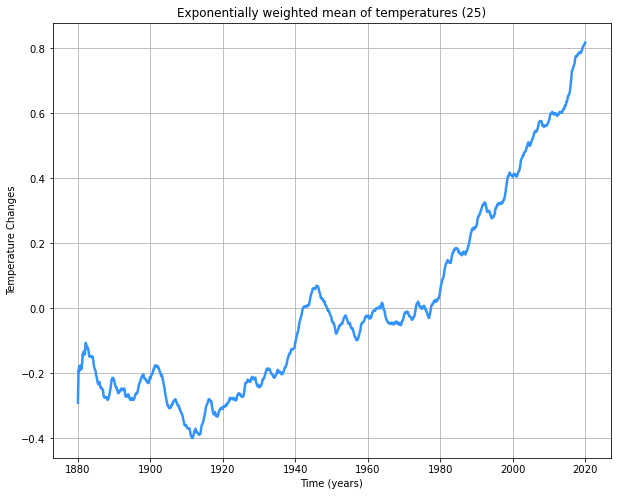

In [41]:
# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot co2 emissions data with specific colour and line thickness
ax.plot(temp_chg['Avg_Anomaly_deg_C'].ewm(span=100).mean(), color='#3393FF', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (years)', ylabel='Temperature Changes',
       title='Exponentially weighted mean of temperatures (25)')

# Enable grid
ax.grid()

## Wrangling Emissions

In [42]:
raw_e

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,204.631696,208.837879,226.081890,214.785217,207.626699,185.213644,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.906060,0.922474,0.930816,0.940570,0.996033,1.047280,...,1.021646,1.031833,1.041145,0.987393,0.971016,0.959978,0.933541,NaN,NaN,NaN
2,Afghanistan,AFG,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.046057,0.053589,0.073721,0.074161,0.086174,0.101285,...,0.335351,0.263716,0.234037,0.232176,0.208857,0.203328,0.200151,NaN,NaN,NaN
3,Africa Western and Central,AFW,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.090880,0.095283,0.096612,0.112376,0.133258,0.184803,...,0.490867,0.504655,0.507671,0.480743,0.472959,0.476438,0.515544,NaN,NaN,NaN
4,Angola,AGO,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.100835,0.082204,0.210533,0.202739,0.213562,0.205891,...,1.204799,1.261542,1.285365,1.260921,1.227703,1.034317,0.887380,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,"Yemen, Rep.",YEM,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.011038,0.013599,0.012729,0.014518,0.017550,0.017926,...,0.804146,1.047834,1.034330,0.536269,0.400468,0.361418,0.326682,NaN,NaN,NaN
263,South Africa,ZAF,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,5.727223,5.832621,5.887168,5.961337,6.332343,6.616545,...,8.076633,8.137333,8.213158,7.671202,7.564451,7.632729,7.496645,NaN,NaN,NaN
264,Zambia,ZMB,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,NaN,NaN,NaN,NaN,0.946606,1.096875,...,0.277909,0.284058,0.311693,0.319282,0.341615,0.414748,0.446065,NaN,NaN,NaN


In [43]:
raw_e[raw_e['Country Name']=='World']

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
259,World,WLD,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,3.121158,3.06809,3.114839,3.221195,3.324046,3.432395,...,4.578768,4.610229,4.560774,4.48877,4.436759,4.441309,4.483524,NaN,NaN,NaN


### Activity

Extract the record that has world data and keep only the columns 1960 to 2019
Form a new table named emissions that looks like :

<img src="https://github.com/usm-cos422-522/courseMaterials/raw/main/Lectures/img/EmissionsTable.png">


#### Activity

display all emissions after the year 2006


#### Activity

display emissions between November 21, 1985 to Jan 4th, 2001


#### Activity
 Make a plot of emissions that looks like :
<img src="https://github.com/usm-cos422-522/courseMaterials/raw/main/Lectures/img/EmissionsPlot.png">



#### Activity

Create a plot of rolling mean with window size = 25


#### Activity

Create a plot of exponentially weighted mean with a window span of 15
